In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# From the tutorial
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


def s3(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y

def partition_weights(n,n0):
    p0 = n0*n
    y = np.zeros((n,p0))
    for i in range(n):
        y[i,i*n0:(i+1)*n0] = 1.
    return y 

def partition_bias(n,n0):
    p0 = n0*n
    return (np.arange(0.,p0)%n0)    

def spline_function_(n,m,c0,u0):
    """
    Function from [0,1]^n to R^m
    n  - Input dimension
    m  - output dimension
    c0 - the capacity of the network, the number of control points for each input variable is proportional capacity
    u0 - the initial value of all control points
    """
    
    d0 = 3 
 
    n0 = c0 + d0 # the number of control points; capacity + degree of basis function
    p0 = n0*n

    w0 = tf.constant_initializer(c0*partition_weights(n,n0))
    b0 = tf.constant_initializer(d0 - partition_bias(n,n0))
    
    w1 = tf.constant_initializer(0.)

    inn = tf.keras.layers.Input(shape=(n,))

    l00 = tf.keras.layers.Dense(activation=s3,
                                units=p0,
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=w0,
                                bias_initializer=b0 
                               )(inn)          # Modified
    
    out = tf.keras.layers.Dense(units=m,
                                use_bias=False,
                                trainable=True,
                                kernel_initializer=w1
                               )(l00)

    model = tf.keras.Model(inputs=inn, 
                           outputs= out
                          )
    return model

TensorFlow version:  2.1.0


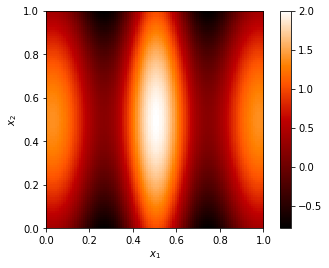

In [2]:
# Target function plot

def f(x,y):
    v0 = np.cos(4.*np.pi*x)*np.exp(-4*(x-0.5)**2) + np.sin(1.*np.pi*y)
    return v0

resolution = 0.01

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

x0, x1 = np.meshgrid(x0, x1)
y0 = f(x0,x1)

img = plt.imshow(y0, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 128       
Total params: 512
Trainable params: 128
Non-trainable params: 384
_________________________________________________________________


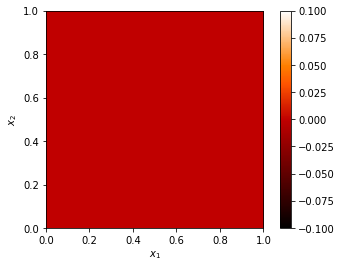

In [3]:
# Initialise a model
# n,m,r,k,u0,h0
n   = 2
m   = 1
c0  = 61
u0  = 0.

model = spline_function_(n,m,c0,u0)


# Print model summary
model.summary()

# Adjust weights for testing purposes, comment out otherwise
#weights = model.get_weights()



# Change index value to inspect the model
#index = 73 #change this value
#weights[2][index] = 1.
#model.set_weights(weights)


output1 = model.predict(coordinates).reshape(100,100)

img = plt.imshow(output1, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [4]:
# Data Generation 
# randomly and uniformly sampled 


rs = np.random.RandomState(16989)

#train_inputs = np.random.rand(10000,2)
train_inputs = rs.rand(10000,2)

z0 = train_inputs[:,0]
z1 = train_inputs[:,1]

train_output = f(z0,z1)

In [5]:
#Define the Keras TensorBoard callback.
logdir="logs/fit/SAM_Task1_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

In [7]:
model.fit(train_inputs, train_output, epochs=50,verbose=1,callbacks=[tensorboard_callback])

Train on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 177us/sample - loss: 0.5670 - mse: 0.5670
Epoch 2/50
10000/10000 [==============================] - 1s 116us/sample - loss: 0.2833 - mse: 0.2833
Epoch 3/50
10000/10000 [==============================] - 1s 112us/sample - loss: 0.1382 - mse: 0.1382
Epoch 4/50
10000/10000 [==============================] - 1s 118us/sample - loss: 0.0651 - mse: 0.0651
Epoch 5/50
10000/10000 [==============================] - 1s 127us/sample - loss: 0.0295 - mse: 0.0295
Epoch 6/50
10000/10000 [==============================] - 1s 106us/sample - loss: 0.0128 - mse: 0.0128
Epoch 7/50
10000/10000 [==============================] - 1s 116us/sample - loss: 0.0052 - mse: 0.0052
Epoch 8/50
10000/10000 [==============================] - 1s 101us/sample - loss: 0.0020 - mse: 0.0020
Epoch 9/50
10000/10000 [==============================] - 1s 102us/sample - loss: 6.6834e-04 - mse: 6.6834e-04
Epoch 10/50
10000/10000 [=================

In [8]:
output2 = model.predict(coordinates).reshape(100,100)

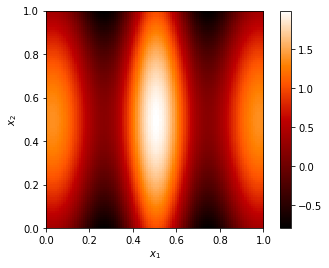

In [9]:
img = plt.imshow(output2, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [10]:
x_test = coordinates
y_test = y0.reshape(10000)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)


Evaluate on test data
10000/10000 [==============================] - 1s 91us/sample - loss: 2.5824e-07 - mse: 2.5824e-07
test loss, test acc: [2.5823821968060655e-07, 2.5823817e-07]


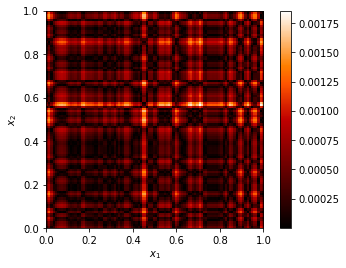

In [11]:
img = plt.imshow(np.abs(output2-y0), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [12]:
y_new = y0.copy()
y_new[44:55,44:55] = 0.

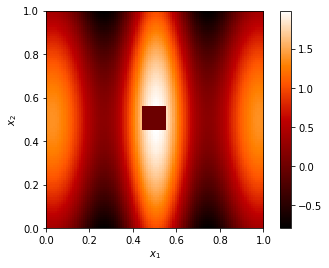

In [13]:
img = plt.imshow(y_new, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [14]:
# New Data
k = 10000

rs2 = np.random.RandomState(13989)

train_inputs_2 = 0.11*rs2.rand(k,2)+0.44
#train_inputs_2 = 0.11*np.random.rand(k,2)+0.44

train_output_2 = np.ones(k)*0.

In [15]:
#Define the Keras TensorBoard callback.
logdir="logs/fit/SAM_Task2_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
model.fit(train_inputs_2, train_output_2, epochs=10,verbose=1,callbacks=[tensorboard_callback])

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 117us/sample - loss: 1.0784 - mse: 1.0784
Epoch 2/10
10000/10000 [==============================] - 1s 128us/sample - loss: 0.0862 - mse: 0.0862
Epoch 3/10
10000/10000 [==============================] - 1s 121us/sample - loss: 0.0073 - mse: 0.0073
Epoch 4/10
10000/10000 [==============================] - 1s 121us/sample - loss: 7.0671e-04 - mse: 7.0671e-04
Epoch 5/10
10000/10000 [==============================] - 1s 128us/sample - loss: 1.3080e-04 - mse: 1.3080e-04
Epoch 6/10
10000/10000 [==============================] - 1s 123us/sample - loss: 3.3937e-05 - mse: 3.3937e-05
Epoch 7/10
10000/10000 [==============================] - 1s 109us/sample - loss: 1.0391e-05 - mse: 1.0391e-05
Epoch 8/10
10000/10000 [==============================] - 1s 105us/sample - loss: 4.3899e-06 - mse: 4.3899e-06
Epoch 9/10
10000/10000 [==============================] - 1s 124us/sample - loss: 2.5181e-06 - mse: 2.5181e-06
Ep

In [17]:
output3 = model.predict(coordinates).reshape(100,100)

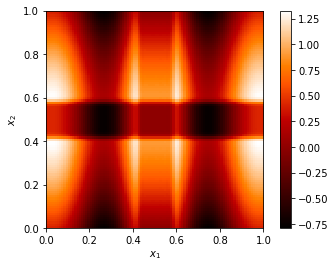

In [18]:
img = plt.imshow(output3, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [19]:
x_test = coordinates
y_test = y_new.reshape(10000)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
10000/10000 [==============================] - 1s 68us/sample - loss: 0.2634 - mse: 0.2634
test loss, test acc: [0.2633802551919223, 0.26338002]


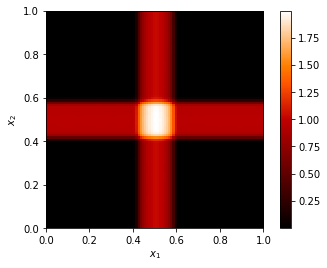

In [20]:
img = plt.imshow(np.abs(output3-output2), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

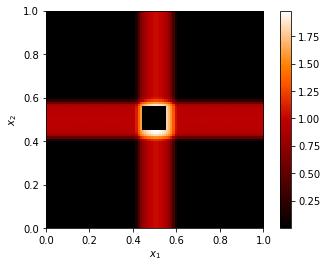

In [21]:
img = plt.imshow(np.abs(output3-y_new), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [22]:
images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

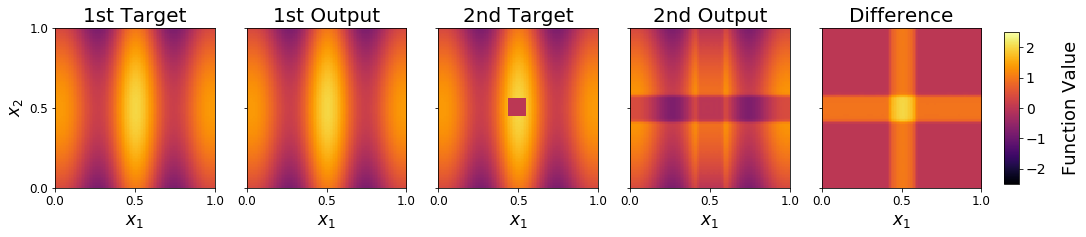

In [23]:
num_rows = 1
num_cols = 1
interpol = 'none' # 'nearest'
xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
yticks = [0,0.5,1]
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][2] # 'inferno'
subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Difference'] #['a','b','c','d','e']

fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
#fig.tight_layout()

for col in range(5):    
    ax = axs[col]
    ax.set_title(subplot_titles[col],fontsize=20)
    ax.set_aspect(1)
    ax.set_xlabel(r'$x_{1}$',fontsize=17)
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', which='major', labelsize=12)
    
    if col==0:
        ax.set_ylabel(r'$x_{2}$',fontsize=17)
        ax.set_yticks(yticks)
        ax.tick_params(axis='y', which='major', labelsize=12)
    pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.])
    #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
    pcm.set_clim(-2.5,2.5)
    
#cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
#cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
cb.set_label(r'Function Value', labelpad=15, size=18)
cb.ax.tick_params(labelsize=14)

fig.savefig("KASAM_Paper_Two_Var_Results/SAM_uniform_b_spline.png", 
            close = True, verbose = True, dpi=500,bbox_inches='tight')

plt.show()